### GUI窗口

In [2]:
import fiftyone as fo
import fiftyone.types as fot
from pathlib import Path
import ty_fo_tools as ty

dataset = fo.load_dataset(fo.list_datasets()[0])
session = fo.launch_app(dataset, port=5151)

- 工作路径

In [4]:
export_dir = Path("/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp")

## 当前View__导出__640子图和对应的labels（coco格式）

### 1. 当前View__导出__原图和lables（coco格式）

- 输入：当前View
- 输出：View里的原图和原图的labels

- 图例
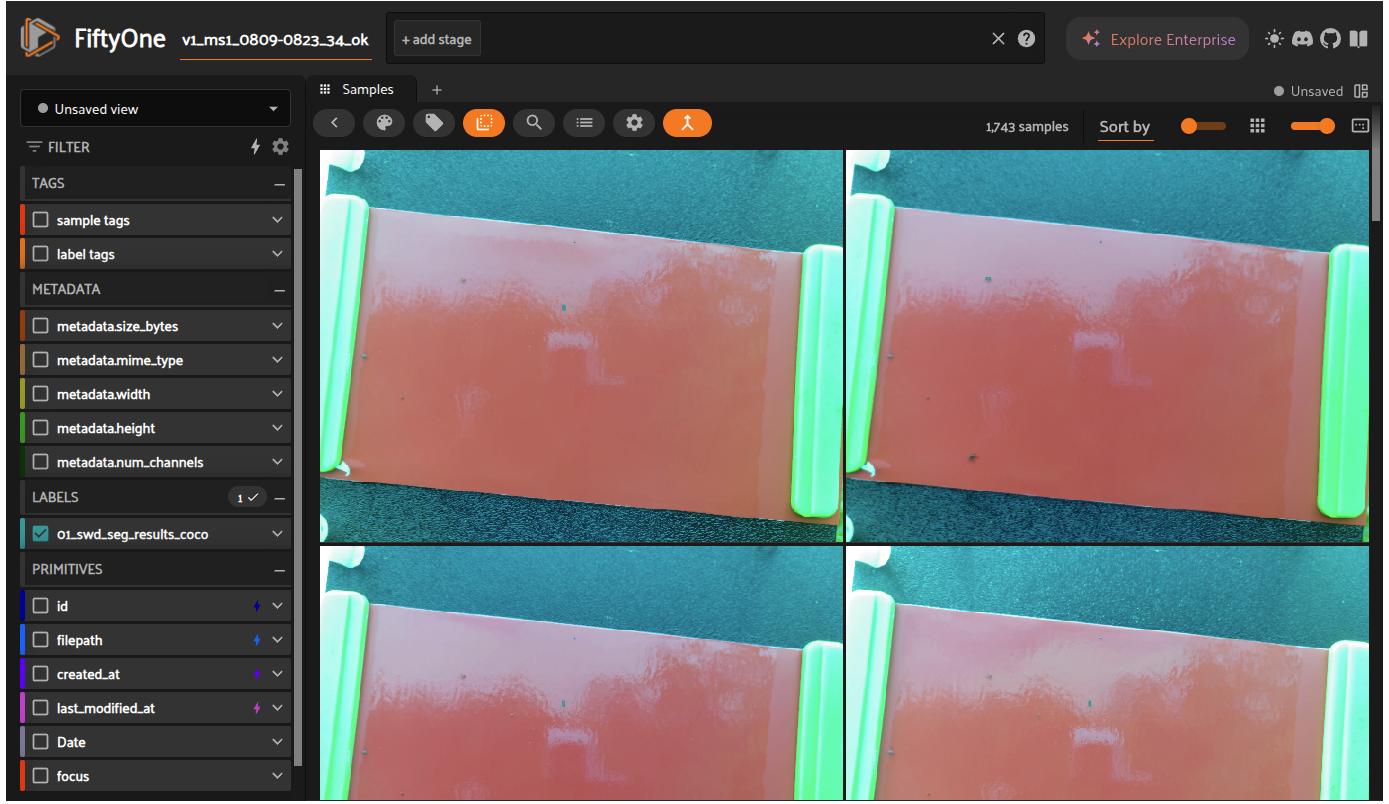
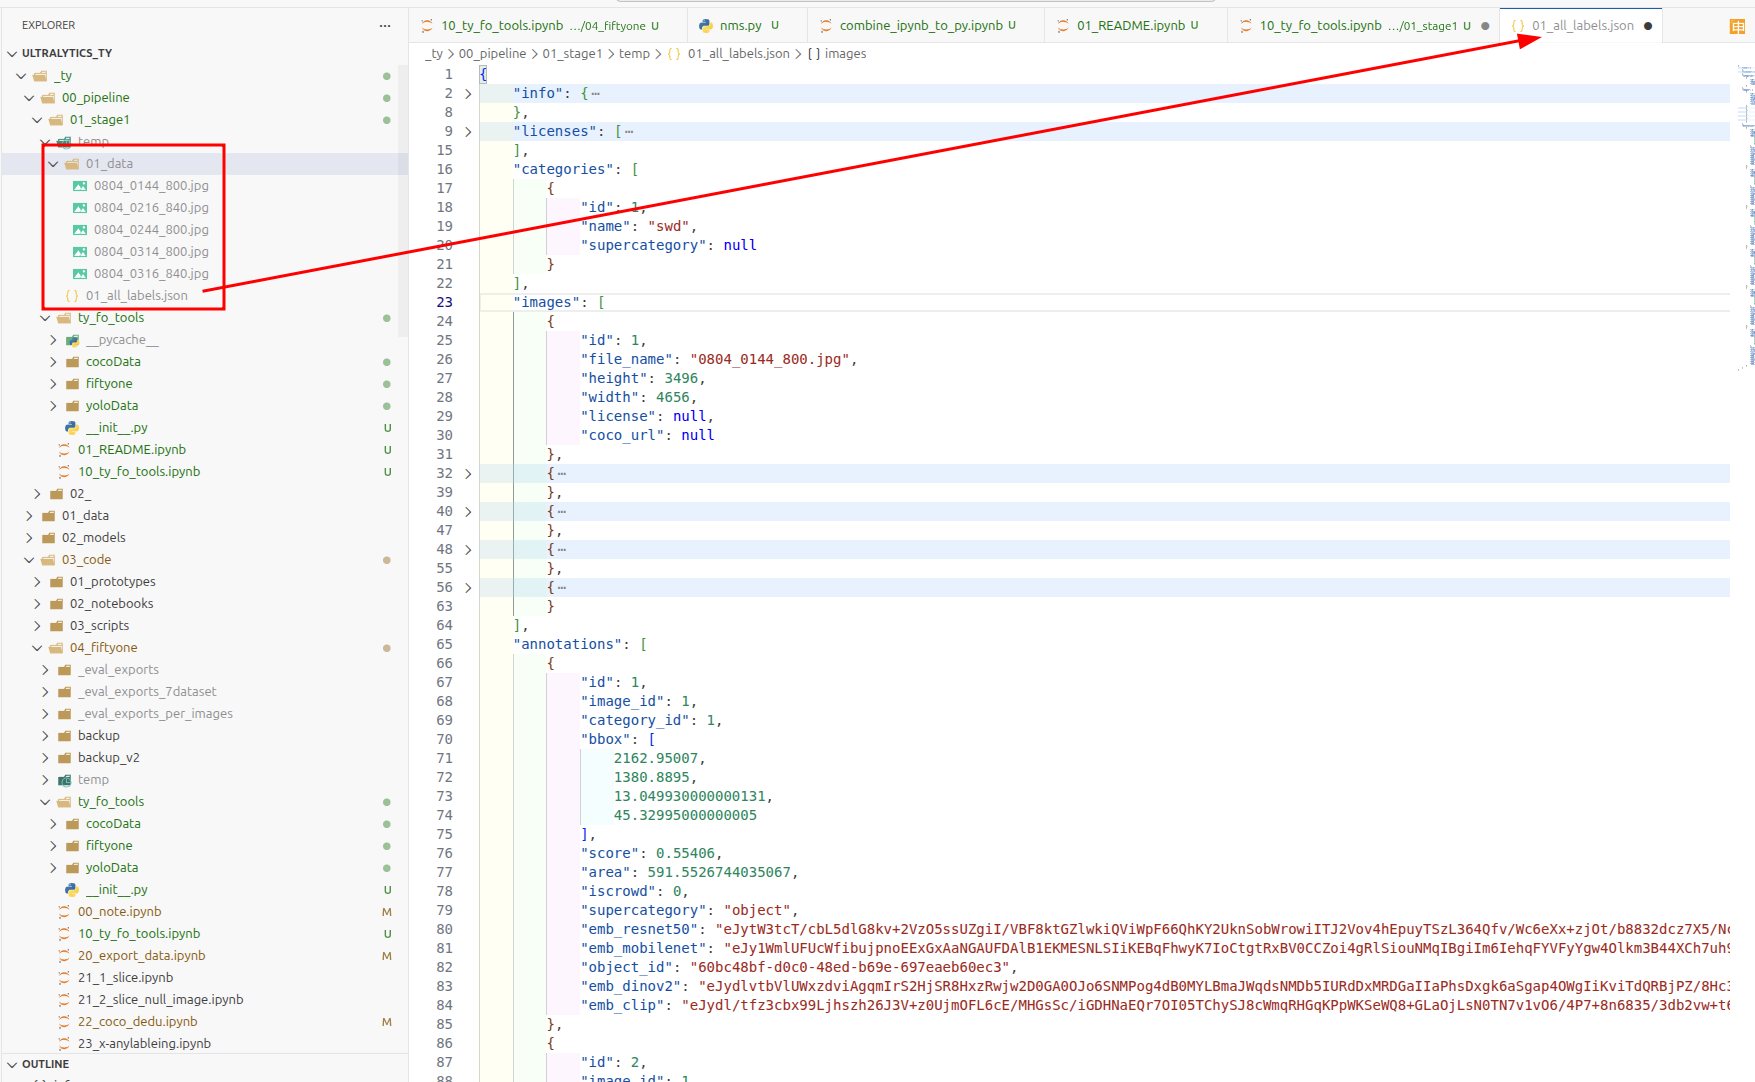

In [9]:
# 1) export current view to COCO
# current_view = session.dataset.view()         #正式运行
current_view = session.dataset[:1].view()      #导出前15张图像进行测试
# current_view =session.dataset.take(10)        #随机抽取10张图像进行导出测试
ty.export_view_to_coco(
    view=current_view,  
    export_dir=export_dir,
    label_field="01_swd_seg_results_coco",
    dataset_type=fot.COCODetectionDataset,
    export_media=True,
    data_dirname=export_dir / "01_data",
    labels_filename=export_dir / "01_all_labels.json",
)
print(f"export files: {export_dir / 'images'},\n {export_dir / '01_all_labels.json'}")

Directory '/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp' already exists; export will be merged with existing files
 100% |█████████████████████| 1/1 [6.9ms elapsed, 0s remaining, 145.1 samples/s] 
export files: /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/images,
 /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/01_all_labels.json


### 2. 原图__切成__640子图和对应的lables
- 输入：原图和原图的labels
- 输出：含有SWD的640子图和对应的640labels

- 图例
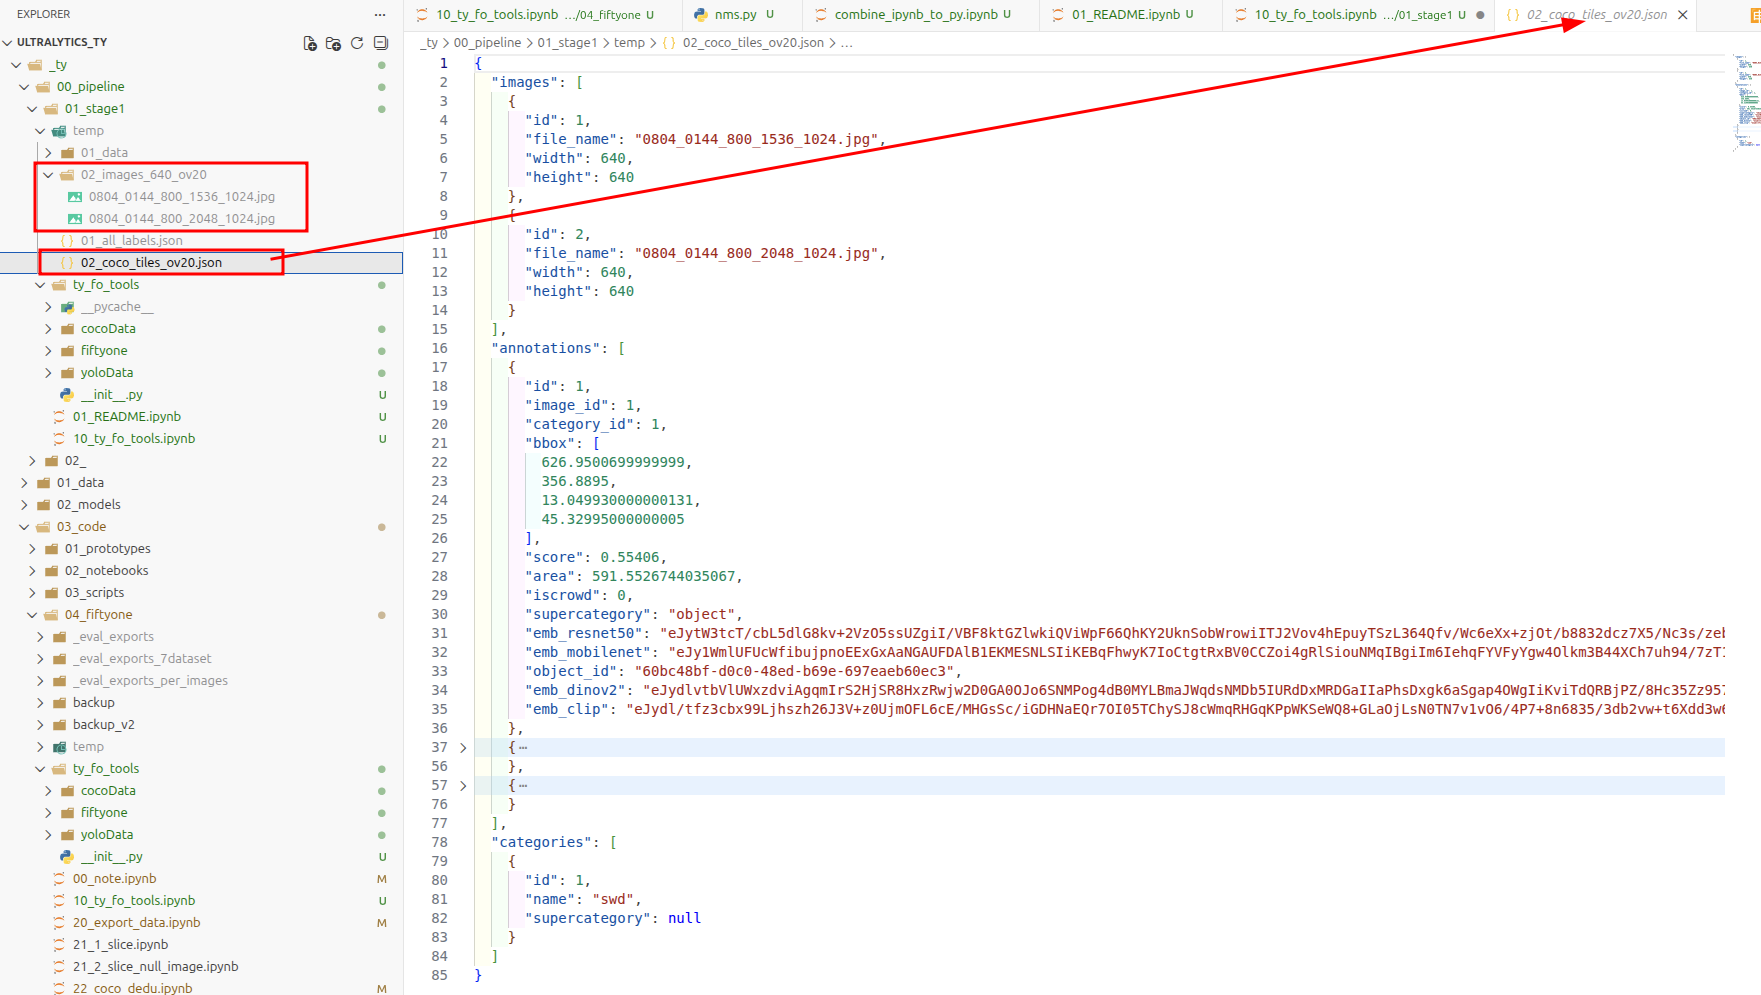

In [10]:
# 2) labeled tiles
spec = ty.TileSpec(crop_size=640, overlap_ratio=0.2, keep_ratio=0.9)
stats = ty.export_labeled_tiles_from_coco(
    img_dir=export_dir / "01_data",
    coco_json=export_dir / "01_all_labels.json",
    out_img_dir=export_dir / "02_images_640_ov20",
    out_json=export_dir / "02_coco_tiles_ov20.json",
    spec=spec,
)
print(f"export files: {export_dir / '02_images_640_ov20'},\n {export_dir / '02_coco_tiles_ov20.json'}")
print(stats)

export files: /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/02_images_640_ov20,
 /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/02_coco_tiles_ov20.json
{'source_images': 1, 'tiles': 2, 'annotations': 3}


### 3. 640子图__去除__重叠的annotation（NMS方法）
- 输入：640子图的lables
- 输出：精简（去重）后的640子图的lables

In [11]:
# 3) NMS on coco tiles json  去除重叠框annotation
nms_stats = ty.coco_nms_json(
    input_json=export_dir / "02_coco_tiles_ov20.json",
    output_json=export_dir / "03_unique_labels.json",
    iou_thresh=0.5,
    per_category=True,
)
print(f"export file: {export_dir / '03_unique_labels.json'}")
print(nms_stats)

export file: /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/03_unique_labels.json
{'before': 3, 'after': 2}


## 原图和原图的labels__导出__k个640子图的null images和labels（YOLO格式）

### 1. 原图和原图的labels__导出__640子图的null images和labels（YOLO格式）

- 图例

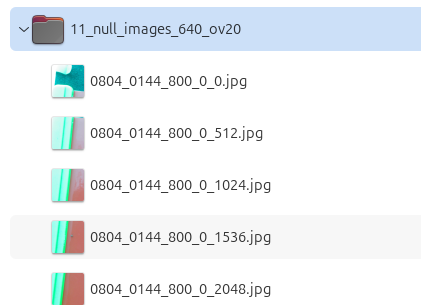

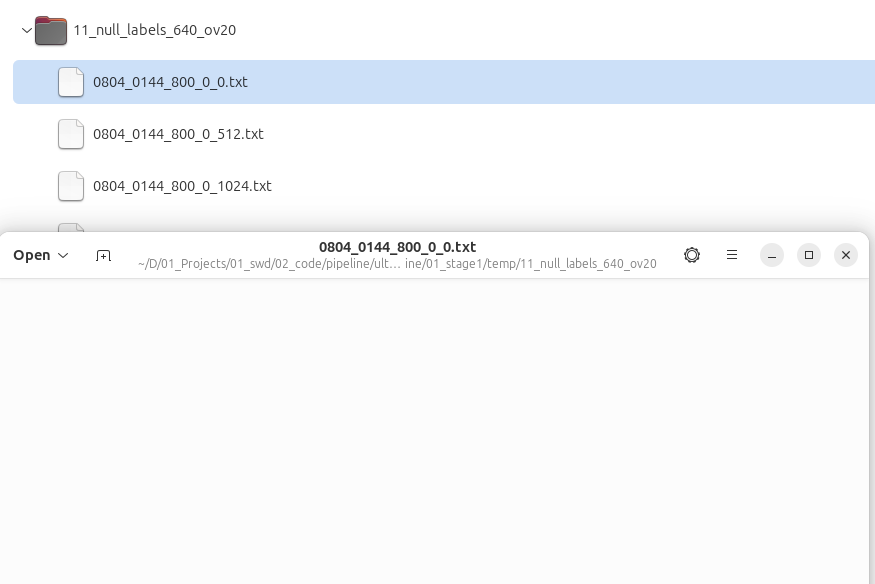

In [12]:
# 1) null tiles
null_stats = ty.export_null_images_tiles_from_coco(
    img_dir=export_dir / "01_data",
    coco_json=export_dir / "01_all_labels.json",
    out_img_dir=export_dir / "11_null_images_640_ov20",
    out_label_dir=export_dir / "11_null_labels_640_ov20",
    spec=spec,
)
print(f"export files: {export_dir / '11_null_images_640_ov20'},\n {export_dir / '11_null_labels_640_ov20'}")
print(null_stats)


export files: /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/11_null_images_640_ov20,
 /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/11_null_labels_640_ov20
{'source_images': 1, 'null_tiles': 61}


### 2. 640子图的null images和labels__随机抽取__k个pairs

- 图例

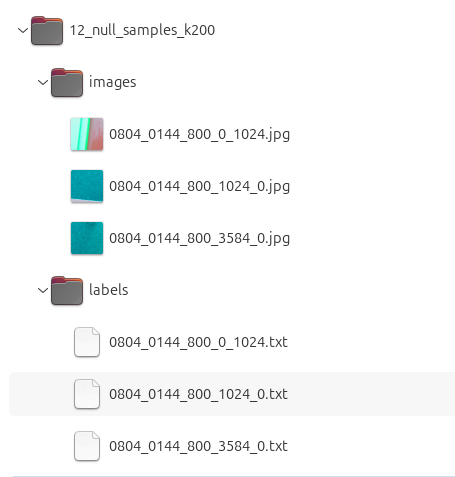

In [ ]:
# 2) sample null tiles
kept = ty.build_yolo_null_images_dataset(
    src_images_dir=export_dir / "11_null_images_640_ov20",
    src_labels_dir=export_dir / "11_null_labels_640_ov20",
    out_root_dir=export_dir / "12_null_samples_k200",
    k=200,
    seed=42,
    strict_pair=True,
    strict_count=False,
)
print("export dir:", export_dir / "12_null_samples_k200")
print("sampled:", kept)

export dir: /home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/00_pipeline/01_stage1/temp/12_null_samples_k200
sampled: 3


# 2

In [12]:
"""
FiftyOne工具箱完整使用示例
"""
import sys
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional

# 添加工具箱到路径（如果包不在Python路径中）
# sys.path.append("/path/to/fiftyone_toolkit")

import fiftyone as fo
import pandas as pd
import plotly.graph_objects as go

# 导入工具箱
import fiftyone_toolkit as fot
from fiftyone_toolkit.types import (
    SliceConfig, 
    DatasetConfig, 
    EvaluationResult,
    BoundingBox,
    CocoDataset
)

ModuleNotFoundError: No module named 'fiftyone_toolkit'

In [ ]:
from pathlib import Path
import ty_fiftyone_toolkit as fot

# 1. 创建数据集
dataset = fot.create_dataset_from_coco(
    name="my_dataset",
    data_path="/path/to/images",
    labels_path="/path/to/labels.json",
    label_field="ground_truth",
    reset_if_exists=True,
)



In [ ]:
# 2. 添加时间和焦点信息
fot.add_time_focus_info(dataset)
fot.create_index_fields(dataset, ["Date", "focus"])



In [ ]:
# 3. 切片数据集
config = fot.SliceConfig(
    crop_size=640,
    overlap_ratio=0.2,
    keep_ratio=0.9,
    remove_empty=True,
)

stats = fot.slice_coco_dataset(
    config=config,
    image_dir=Path("/path/to/images"),
    coco_json=Path("/path/to/labels.json"),
    output_image_dir=Path("/output/images_640"),
    output_json=Path("/output/sliced_labels.json"),
)

print(f"切片统计: {stats}")



In [ ]:
# 4. 加载模型并推理
model = fot.load_detection_model(
    model_path="/path/to/model.pt",
    model_type="yolov8",
    confidence_threshold=0.1,
    device="cuda",
)

fot.run_sahi_slicing(
    dataset=dataset,
    model=model,
    pred_field="predictions",
    slice_height=640,
    slice_width=640,
    overlap_ratio=0.2,
)

# 5. 评估模型
results = fot.evaluate_model_on_dataset(
    dataset=dataset,
    pred_field="predictions",
    gt_field="ground_truth",
    confidence_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9],
)

print(results)